In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

Running on: cuda


In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)
print("MNIST Loaded")

100%|██████████| 9.91M/9.91M [00:39<00:00, 250kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 57.9kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]

MNIST Loaded


In [3]:
tiny_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

tiny_path = './tiny-imagenet/train'

tiny_data = datasets.ImageFolder(root=tiny_path, transform=tiny_transform)
tiny_loader = DataLoader(tiny_data, batch_size=64, shuffle=True)
print("TinyImageNet Loaded")

TinyImageNet Loaded


In [4]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10) 

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.fc1(x)
        return x

model_mnist = CNN_MNIST().to(device)

In [5]:

class CNN_TINY(nn.Module):
    def __init__(self):
        super(CNN_TINY, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        
        self.fc1 = nn.Linear(128 * 8 * 8, 200)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc1(x)
        return x

model_tiny = CNN_TINY().to(device)

In [6]:
def train_model(model, loader, optimizer, criterion, name, num_epochs=5):
    model.train()
    print(f"Training {name} ")
    
    for epoch in range(num_epochs):
        curr_loss = 0
        
        for i, (ips, label) in enumerate(loader):
            ip, labels = ips.to(device), label.to(device)
            optimizer.zero_grad()
            
            op = model(ip)
            loss = criterion(op, labels)
            
            loss.backward()
            optimizer.step()
            
            curr_loss += loss.item()
            
        avg_loss = curr_loss / len(loader)
        print(f"Epoch {epoch+1} => Loss: {avg_loss:.4f}")

In [7]:
crit = nn.CrossEntropyLoss()

opt_MNIST = optim.Adam(model_mnist.parameters(), lr=0.001)
train_model(model_mnist, mnist_loader, opt_MNIST, crit, "MNIST")

print('\n')

opt_TINY = optim.Adam(model_tiny.parameters(), lr=0.001)
train_model(model_tiny, tiny_loader, opt_TINY, crit, "TinyImageNet")

Training MNIST 
Epoch 1 => Loss: 0.1357
Epoch 2 => Loss: 0.0454
Epoch 3 => Loss: 0.0330
Epoch 4 => Loss: 0.0256
Epoch 5 => Loss: 0.0193


Training TinyImageNet 
Epoch 1 => Loss: 1.9128
Epoch 2 => Loss: 1.4220
Epoch 3 => Loss: 1.2797
Epoch 4 => Loss: 1.1446
Epoch 5 => Loss: 1.0448


In [10]:
def plot_kernels(tensor, title, channel=None):
    tensor = tensor.cpu()
    
    min_w = tensor.min()
    max_w = tensor.max()
    tensor = (tensor - min_w) / (max_w - min_w)

    if channel is not None:
        N, _, H, W = tensor.shape
        colored_tensor = torch.zeros(N, 3, H, W)
        colored_tensor[:, channel, :, :] = tensor[:, 0, :, :]
        tensor = colored_tensor
    
    grid = utils.make_grid(tensor, nrow=8, padding=1, pad_value=1)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

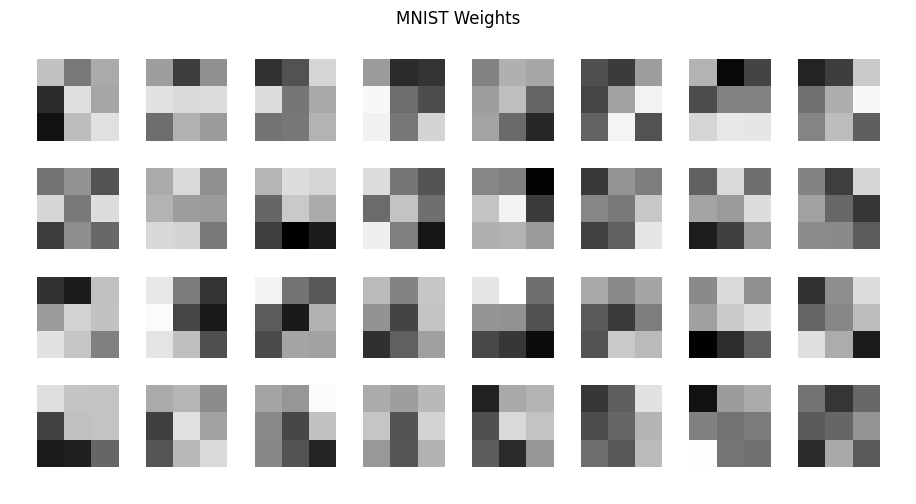

In [11]:
w_mnist = model_mnist.conv1.weight.data 
plot_kernels(w_mnist, "MNIST Weights")

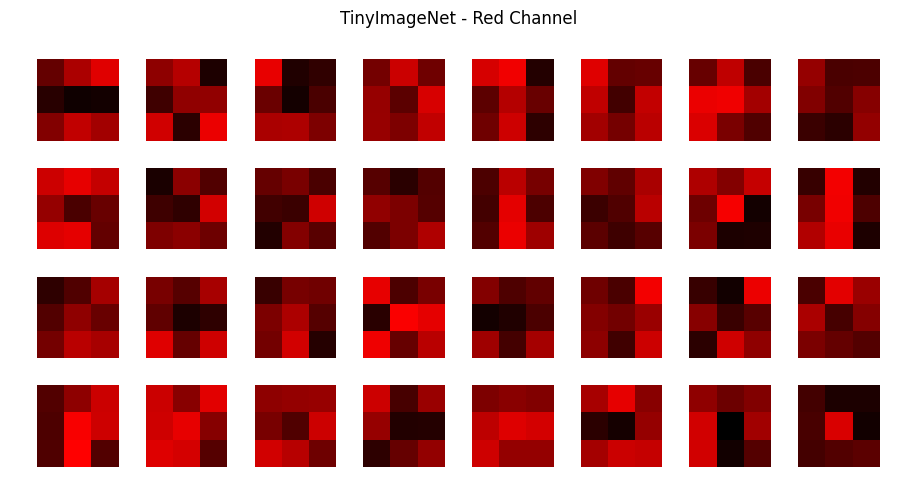

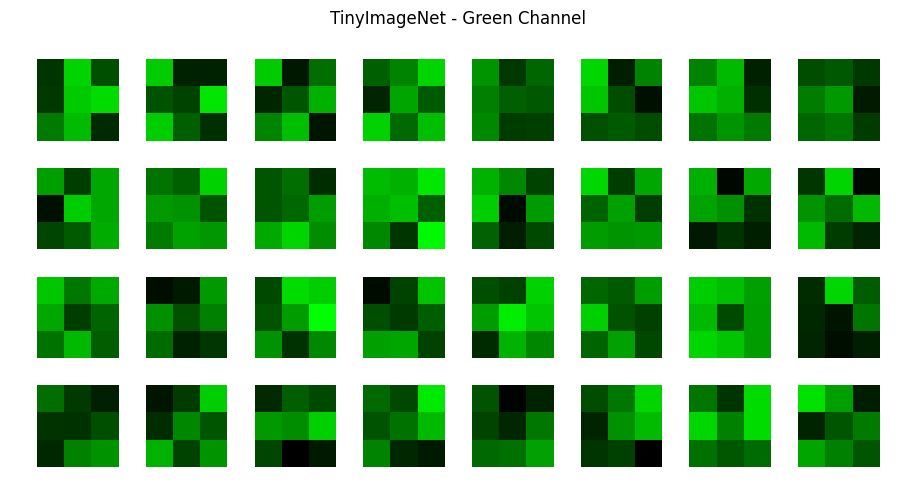

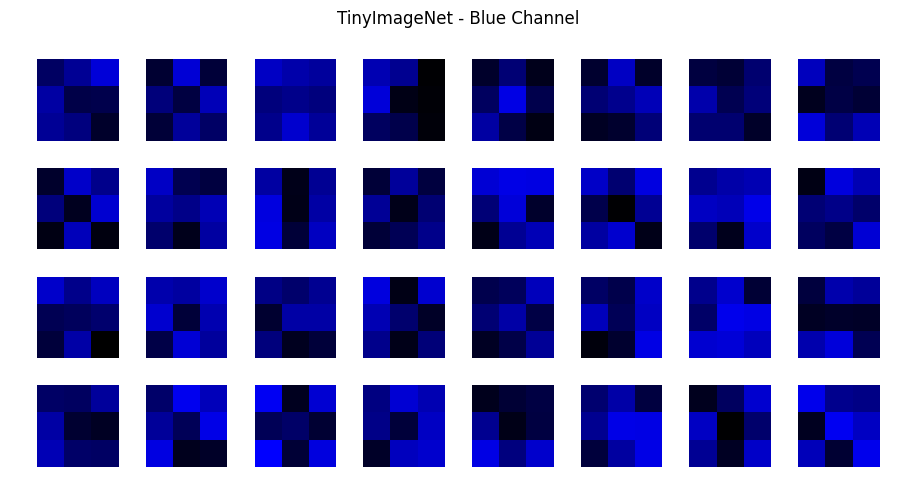

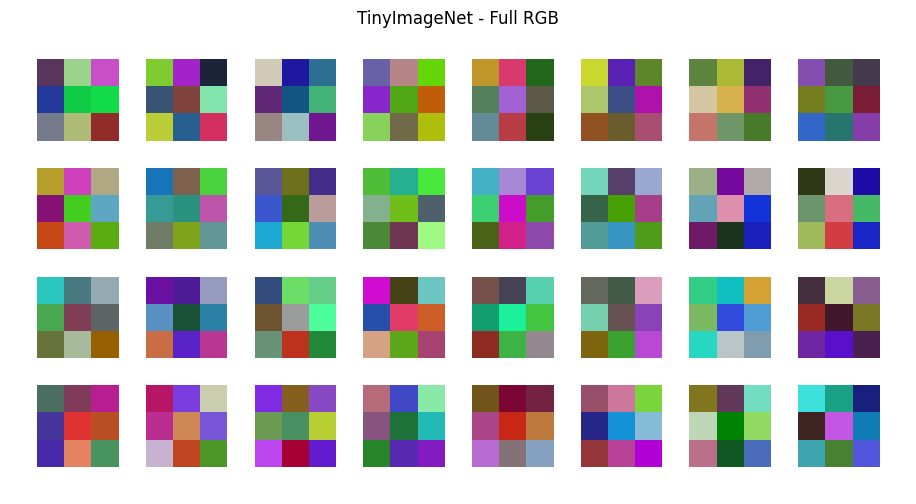

In [12]:
w_tiny = model_tiny.conv1.weight.data 

plot_kernels(w_tiny[:, 0:1], "TinyImageNet - Red Channel", channel = 0)
plot_kernels(w_tiny[:, 1:2], "TinyImageNet - Green Channel", channel = 1)
plot_kernels(w_tiny[:, 2:3], "TinyImageNet - Blue Channel", channel = 2)
plot_kernels(w_tiny, "TinyImageNet - Full RGB")

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [ ]:
def visualize(model, dataset, name, layer_first, layer_last):

    img, _ = dataset[1]
    img = img.unsqueeze(0).to(device) 
    
    h1 = layer_first.register_forward_hook(get_activation('first'))
    h2 = layer_last.register_forward_hook(get_activation('last'))
    
    model.eval()
    _ = model(img)
    
    h1.remove()
    h2.remove()
    
    act_first = activations['first'].squeeze()
    map_first = torch.mean(act_first, dim=0).cpu().numpy()
    
    act_last = activations['last'].squeeze()
    map_last = torch.mean(act_last, dim=0).cpu().numpy()
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    orig_img = img.cpu()[0] .permute(1, 2, 0).numpy()
    
    if orig_img.shape[2] == 1: 
        orig_img = orig_img.squeeze()
        
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
    
    ax[0].imshow(orig_img, cmap='gray' if name=='MNIST' else None)
    ax[0].set_title(f"{name} Original")
    
    ax[1].imshow(map_first, cmap='viridis')
    ax[1].set_title("1st Conv Layer Activation")
    
    ax[2].imshow(map_last, cmap='viridis')
    ax[2].set_title("Final Conv Layer Activation")
    
    plt.show()

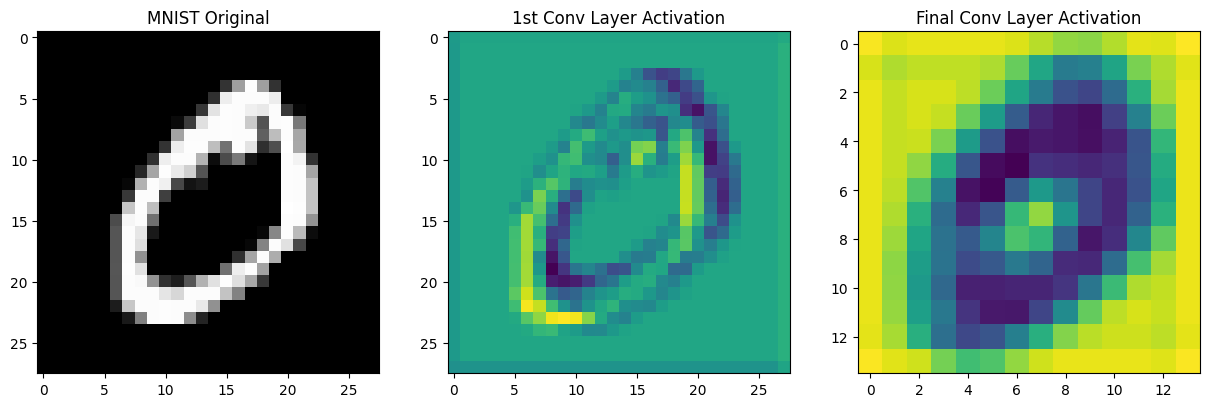

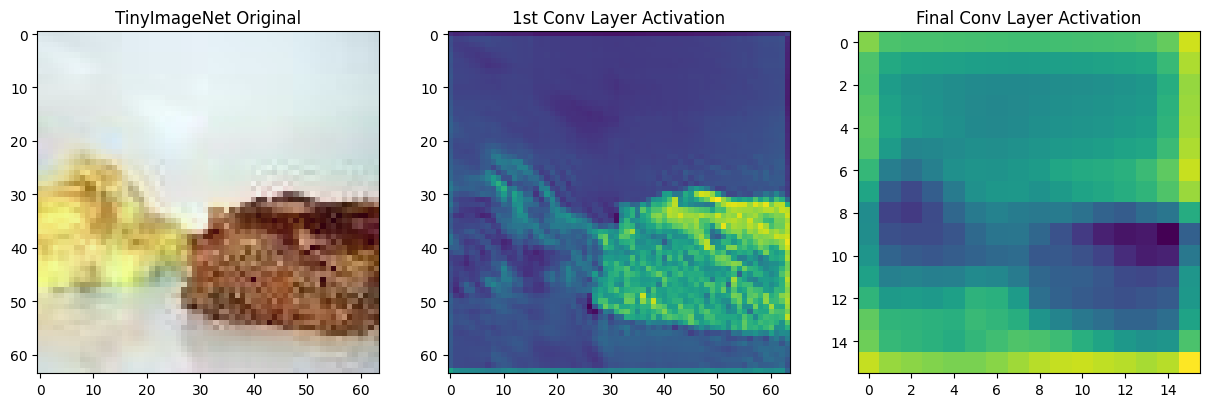

In [31]:
visualize(model_mnist, mnist_data, "MNIST", model_mnist.conv1, model_mnist.conv2)
visualize(model_tiny, tiny_data, "TinyImageNet", model_tiny.conv1, model_tiny.conv3)